# **Project: House Pricing - Advanced Regression Techniques**
**Serkan Burak Örs**

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
import matplotlib.pyplot as plt

In [5]:
# Load the dataset
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

# **Data Preprocession**

In [6]:
# Preprocessing
features = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
categorical_features = ['OverallQual', 'GarageCars', 'FullBath']

# Concatenate train and test data for preprocessing
all_data = pd.concat([train_data[features], test_data[features]])

# Handle missing values
missing_values = all_data.isnull().sum()
missing_features = missing_values[missing_values > 0].index.tolist()
imputer = SimpleImputer(strategy='mean')
all_data[missing_features] = imputer.fit_transform(all_data[missing_features])

# Split features and target variable
X = all_data.iloc[:train_data.shape[0]]
X_test = all_data.iloc[train_data.shape[0]:]
y = train_data['SalePrice']

# Get updated categorical feature names
categorical_feature_names = preprocessor.transformers_[0][1].get_feature_names_out(categorical_features)

NameError: name 'preprocessor' is not defined

# **Feature Engineering**

In [30]:
# Feature Engineering
X = X.copy()  # Create a copy of the DataFrame
X['TotalArea'] = X['GrLivArea'] + X['TotalBsmtSF']
X_test = X_test.copy()  # Create a copy of the DataFrame
X_test['TotalArea'] = X_test['GrLivArea'] + X_test['TotalBsmtSF']

# Handling Categorical Variables
preprocessor = ColumnTransformer(transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
                                remainder='passthrough')

X = preprocessor.fit_transform(X)
X_test = preprocessor.transform(X_test)

# Scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

# **Model Definitions and Hyperparameter Optimisation**

In [31]:
# Model Training and Hyperparameter Tuning
models = {
    'Linear Regression': (LinearRegression(), {}),
    'K-Nearest Neighbors': (KNeighborsRegressor(), {'n_neighbors': [3, 5, 7, 9, 11, 13, 15]}),
    'Decision Tree': (DecisionTreeRegressor(), {'max_depth': [None, 5, 10, 15, 20, 25, 30]}),
    'Random Forest': (RandomForestRegressor(), {'n_estimators': [100, 200, 300, 400, 500, 600, 700]}),
    'Support Vector Machine': (SVR(), {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'rbf']}),
    'XGBoost': (xgb.XGBRegressor(), {'learning_rate': [0.1, 0.01, 0.001], 'max_depth': [3, 5, 7, 9],
                                     'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0]}),
    'Gradient Boosting': (GradientBoostingRegressor(), {'learning_rate': [0.1, 0.01, 0.001, 0.0001],
                                                         'n_estimators': [100, 200, 300, 400],
                                                         'max_depth': [3, 5, 7, 9, 11],
                                                         'subsample': [0.6, 0.8, 1.0],
                                                         'max_features': ['sqrt', 'log2', None]}),
    'Neural Network': (None, {})
}

Tuning parameters for Linear Regression...


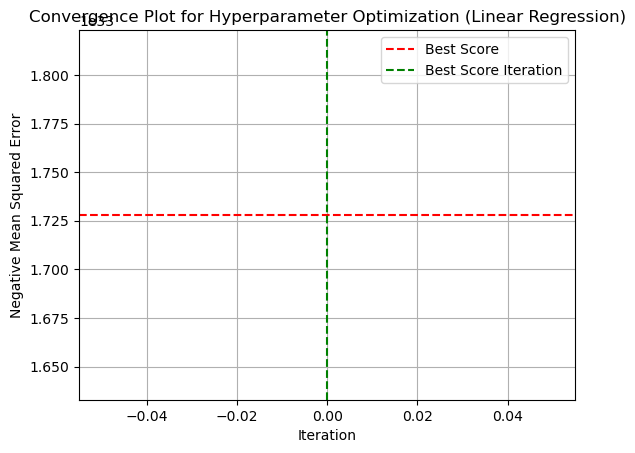

Tuning parameters for K-Nearest Neighbors...


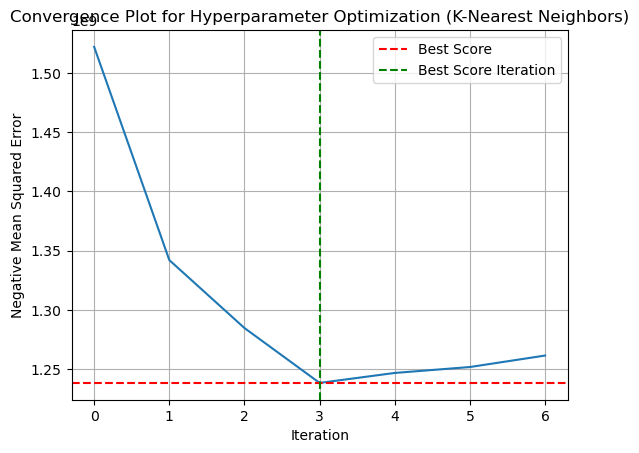

Tuning parameters for Decision Tree...


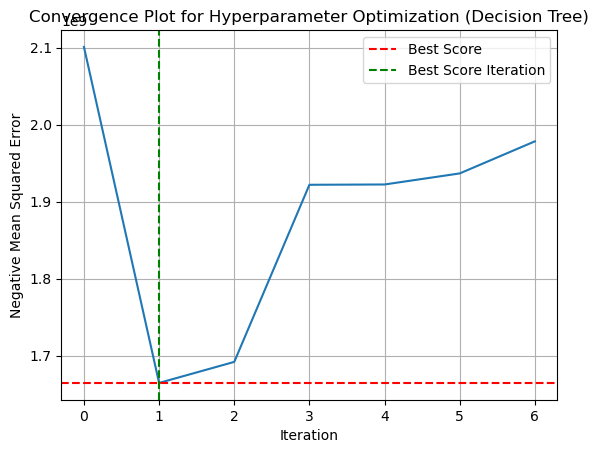

Tuning parameters for Random Forest...


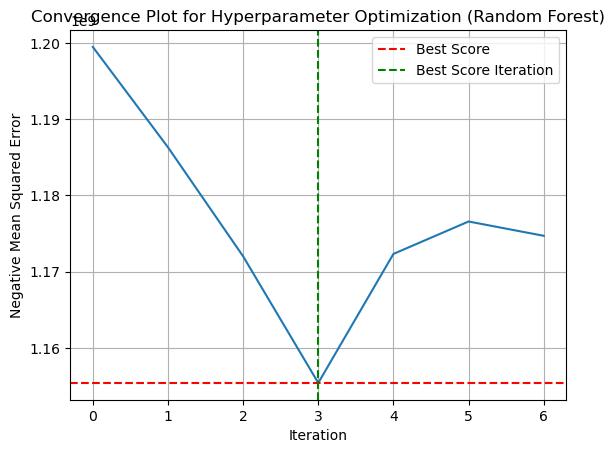

Tuning parameters for Support Vector Machine...


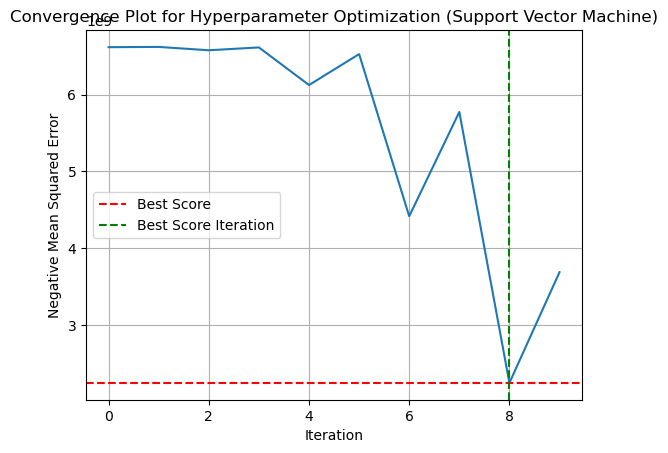

Tuning parameters for XGBoost...


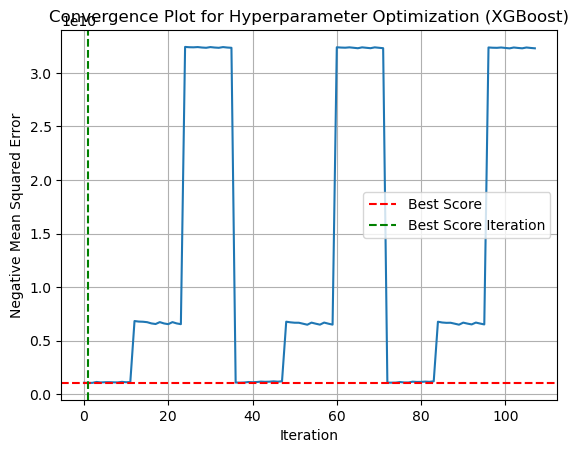

Tuning parameters for Gradient Boosting...


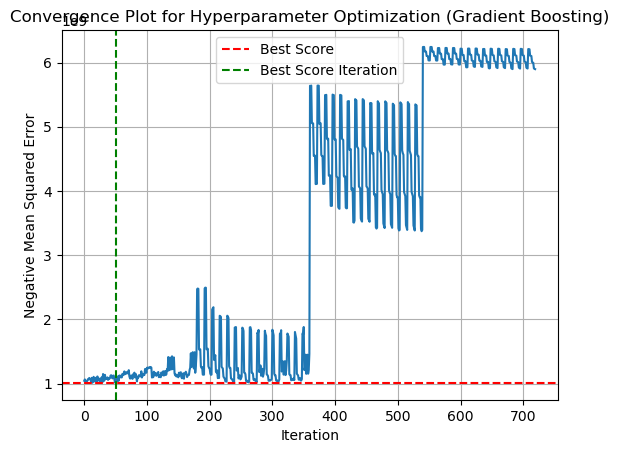

Tuning parameters for Neural Network...


In [32]:
best_models = {}
best_scores = {}

for model_name, (model, param_grid) in models.items():
    print(f'Tuning parameters for {model_name}...')
    if model_name == 'Neural Network':
        class Net(nn.Module):
            def __init__(self, input_size):
                super(Net, self).__init__()
                self.fc1 = nn.Linear(input_size, 64)
                self.fc2 = nn.Linear(64, 32)
                self.fc3 = nn.Linear(32, 1)
                self.relu = nn.ReLU()

            def forward(self, x):
                x = self.relu(self.fc1(x))
                x = self.relu(self.fc2(x))
                x = self.fc3(x)
                return x

        net = Net(X.shape[1])
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y.values, dtype=torch.float32)

        losses = []  # Store the loss values at each epoch

        for epoch in range(1000):
            optimizer.zero_grad()
            outputs = net(X_tensor)
            loss = criterion(outputs.squeeze(), y_tensor)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            
        best_models[model_name] = net
        y_pred = net(X_tensor).detach().numpy()
        best_scores[model_name] = np.sqrt(mean_squared_error(y, y_pred))  
    else:
        grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=5)
        res = grid_search.fit(X, y)

        # Extract information from res object
        mean_test_scores = -res.cv_results_['mean_test_score']
        best_score = -res.best_score_
        best_score_index = res.best_index_

        # Plot convergence of hyperparameter optimization
        plt.plot(mean_test_scores)
        plt.axhline(y=best_score, color='r', linestyle='--', label='Best Score')
        plt.axvline(x=best_score_index, color='g', linestyle='--', label='Best Score Iteration')
        plt.xlabel('Iteration')
        plt.ylabel('Negative Mean Squared Error')
        plt.title(f'Convergence Plot for Hyperparameter Optimization ({model_name})')
        plt.legend()
        plt.grid(True)
        plt.show()

        best_models[model_name] = grid_search.best_estimator_
        best_scores[model_name] = best_score

# **Evaluation of the Methods**

In [16]:
# Evaluation
for model_name, model in best_models.items():
    print(f'{model_name} RMSE: {best_scores[model_name]}')

Linear Regression RMSE: 1.7279860259032714e+33
K-Nearest Neighbors RMSE: 1238205975.828674
Decision Tree RMSE: 1656928990.6424556
Random Forest RMSE: 1172216940.246307
Support Vector Machine RMSE: 2242077442.048245
XGBoost RMSE: 1037915266.0347468
Gradient Boosting RMSE: 994849575.9466407
Neural Network RMSE: 163285.59347109805


# **Feature Importance**

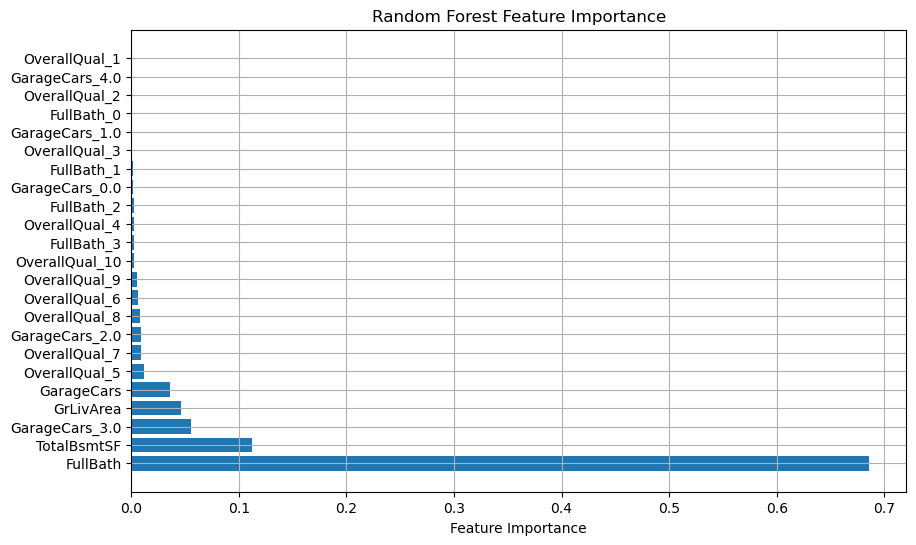

In [24]:
# Feature Importance Visualization (for models that support it)
if 'Random Forest' in best_models:
    feature_importances = best_models['Random Forest'].feature_importances_
    # Update the feature names and feature importances
    feature_names = np.concatenate((categorical_feature_names, features[1:]))
    sorted_indices = np.argsort(feature_importances)[::-1]

    # Adjust the feature names and feature importances to have the same length
    if len(feature_names) > len(feature_importances):
        feature_names = feature_names[:-1]

    # Plot the feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_names)), feature_importances[sorted_indices])
    plt.yticks(range(len(feature_names)), feature_names[sorted_indices])
    plt.xlabel('Feature Importance')
    plt.title('Random Forest Feature Importance')
    plt.grid(True)
    plt.show()

# **Prediction and Submission**

In [25]:
# Prediction
predictions = {}

for model_name, model in best_models.items():
    if model_name == 'Neural Network':
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        predictions[model_name] = model(X_test_tensor).detach().numpy().squeeze()
    else:
        predictions[model_name] = model.predict(X_test)

In [33]:
# Submit the predictions
for model_name, preds in predictions.items():
    submission = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': preds})
    submission.to_csv(f'submission_{model_name}.csv', index=False)

**By comparing the scores evaluated by Kaggle auto grade, the most accurate method is Gradient Boosting Regressor for this project**

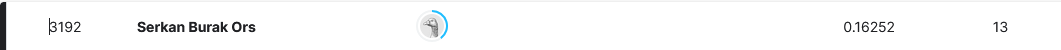